In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
f1_score, roc_auc_score, roc_curve, precision_score, recall_score, auc
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
!git clone https://github.com/sirius-devel/datasets_for_studing2.git

Cloning into 'datasets_for_studing2'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 0), reused 6 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), 521.90 KiB | 10.87 MiB/s, done.


In [56]:
df = pd.read_csv("/content/datasets_for_studing2/Titanic-Dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [57]:
def missing_values_stat(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending = False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending = False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [58]:
#определем количество пустых ячеек (пункт 4 ДЗ)
missing_values_stat(df)

          n_miss  ratio
Cabin        687  77.10
Age          177  19.87
Embarked       2   0.22


In [59]:
#заполняем пустые ячейки столбца Age (пункт 5 ДЗ)
average_age_of_passenger = df["Age"].mean()
print(average_age_of_passenger)
df.loc[:,"Age"].fillna(average_age_of_passenger, inplace=True)

29.69911764705882


In [60]:
#В столбце каюта ( 'Cabin') не указано 687 значений.  Проверим - существует ли какая-то систематическая взаимосвязь между выживанием и тем, была ли у пассажира отдельная каюта.
#Используем метод groupby() для группуровки.
#True - отсутствует упоминание о каюте; False - значение заполнено
df.groupby(df['Cabin'].isnull()).mean(numeric_only = True)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Cabin,,,,,,,
False,455.401961,0.666667,1.196078,35.258349,0.441176,0.436275,76.141504
True,443.208151,0.299854,2.639010,28.048341,0.547307,0.365357,19.157325


In [61]:
#Из пассажиров, у кого запись о каюте отсутствует - выжили около 30%. А у кого запись о наличии каюты есть - выжило 67%.
#Вывод: Есть взаимосвязь между выживанием и наличием каюты. (положительное влияние наличия Cabin на Survived, пункт 8 ДЗ)
#Поэтому создадим новую колонку 'Cabin_available' (бинарный классификатор).Если значение в колонке 'Cabin' отсутствует, то присваиваем в колонке 'Cabin_available' - значение 0,
#если присутствует, то 1.
df['Cabin_available'] = np.where(df['Cabin'].isnull(), 0, 1)
df.head(6)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_available
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,0
5,6,0,3,"Moran, Mr. James",male,29.699118,0,0,330877,8.4583,NaN,Q,0


In [62]:
#Выживаемость пассажиров в зависимости от наличия записи о каюте - у кого запись о каюте отсутствует - выжили около 30%. А у кого запись о наличии каюты есть - выжило 67%.
#Вывод: Наличие отдельной каюты положительно повлияло на выживаемость.
df.groupby(['Cabin_available']) ['Survived'].value_counts(normalize=True)


Cabin_available  Survived
0                0           0.700146
                 1           0.299854
1                1           0.666667
                 0           0.333333
Name: Survived, dtype: float64

In [63]:
#удаляем столбец Cabin, вместо него был создан и заполнен непустыми значениями новый столбец Cabin_available (пункт 5 ДЗ)
df.drop(['Cabin'], axis = 1, inplace = True)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_available
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,S,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,S,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,S,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C,1


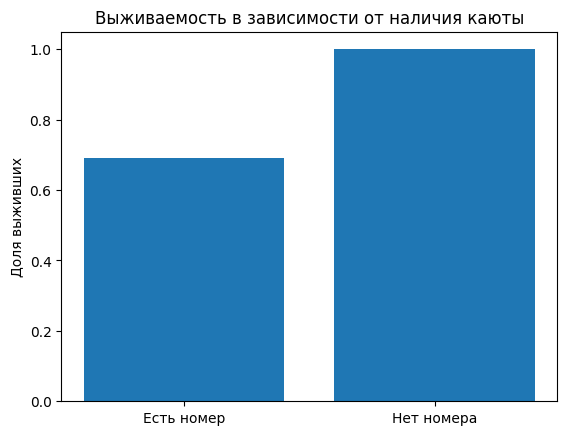

In [64]:
#Выделим пассажиров в группы
have_cabin = df.loc[(df['Cabin_available'])]
have_cabin_survived = df.loc[(df['Cabin_available'] == 1 & (df['Survived'] == 1))]
no_cabin = df.loc[df['Cabin_available'] == 0]
no_cabin_survived = df.loc[(df['Cabin_available'] == 0 & (df['Survived'] == 1))]

#Визуализируем долю выживших
fig, ax = plt.subplots()
ax.bar(('Есть номер', 'Нет номера'), (len(have_cabin_survived)/len(have_cabin), len(no_cabin_survived)/len(no_cabin)))
ax.set_ylabel('Доля выживших')
ax.set_title('Выживаемость в зависимости от наличия каюты')
plt.show()

In [65]:
#В колонке порт посадки на борт ('Embarked') не указано два значения. Это категориальный признак.
#Заменим отсутствующее значение значением, которым чаще всего встречается в конкретном столбце.
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [66]:
#Чаще всего встречается значение S - 644. Заменяем пропущенные значения на S.
df['Embarked'].replace(np.nan, 'S', inplace = True)
df['Embarked'].describe()

count     891
unique      3
top         S
freq      646
Name: Embarked, dtype: object

In [67]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_available
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0


In [68]:
#Заменяем значение пола для мужчин на 1, а для женщин на 0
df['Male'] = np.where(df['Sex'] == 'male', 1, 0)

In [69]:
#Теперь столбец 'Sex' можно удалить, всесто него создан столбец Male
df.drop(['Sex'], axis = 1, inplace = True)

In [70]:
df.groupby("Male").size()

Male
0    314
1    577
dtype: int64

In [71]:
#Среди представительниц женского пола выживших - 74%, среди представителей мужского пола выживших - 18,9%
#Вывод: принадлежность мужскому полу отрицательно влияла на выживаемость (отрицательное влияние принадлежности к мужскому полу на Survived, пункт 8 ДЗ)
df.groupby(["Male"])["Survived"].value_counts(normalize=True)

Male  Survived
0     1           0.742038
      0           0.257962
1     0           0.811092
      1           0.188908
Name: Survived, dtype: float64

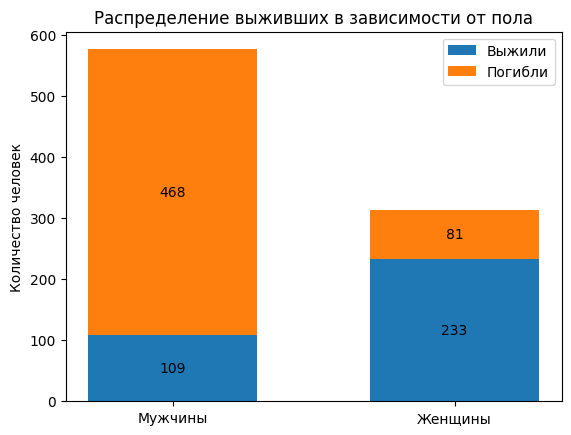

In [73]:
#Посчитаем общее количество мужчин и женщин, а также количество выживших
males_total = len(df.loc[(df['Male'] == 1)])
females_total = len(df.loc[(df['Male'] == 0)])
males_survived = len(df.loc[((df['Male'] == 1) & (df['Survived'] == 1))])
females_survived = len(df.loc[((df['Male'] == 0) & (df['Survived'] == 1))])

#Визуализируем
survivors_counts = {
    'Выжили': [males_survived, females_survived],
    'Погибли': [males_total - males_survived, females_total - females_survived]
}

fig, ax = plt.subplots()
bottom = np.zeros(2)

for key, count in survivors_counts.items():
    p = ax.bar(('Мужчины', 'Женщины'), count, width = 0.6, label = key, bottom = bottom)
    bottom += count
    ax.bar_label(p, label_type = 'center')

ax.set_title('Распределение выживших в зависимости от пола')
ax.set_ylabel('Количество человек')
ax.legend()
plt.show()

In [74]:
#Теперь наш набор данных не содержит пропущенных значений
df.isnull().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Embarked           0
Cabin_available    0
Male               0
dtype: int64

In [75]:
#Описание всех колонок; для некатегориальных признаков видим минимальное и максимальное значение (пункт 7 ДЗ)
display(df.describe(include = 'all'))

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_available,Male
count,891.000000,891.000000,891.000000,891,891.000000,891.000000,891.000000,891,891.000000,891,891.000000,891.000000
unique,NaN,NaN,NaN,891,NaN,NaN,NaN,681,NaN,3,NaN,NaN
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",NaN,NaN,NaN,347082,NaN,S,NaN,NaN
freq,NaN,NaN,NaN,1,NaN,NaN,NaN,7,NaN,646,NaN,NaN
mean,446.000000,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,0.228956,0.647587
std,257.353842,0.486592,0.836071,NaN,13.002015,1.102743,0.806057,NaN,49.693429,NaN,0.420397,0.477990
min,1.000000,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,22.000000,0.000000,0.000000,NaN,7.910400,NaN,0.000000,0.000000
50%,446.000000,0.000000,3.000000,NaN,29.699118,0.000000,0.000000,NaN,14.454200,NaN,0.000000,1.000000
75%,668.500000,1.000000,3.000000,NaN,35.000000,1.000000,0.000000,NaN,31.000000,NaN,0.000000,1.000000


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      891 non-null    int64  
 1   Survived         891 non-null    int64  
 2   Pclass           891 non-null    int64  
 3   Name             891 non-null    object 
 4   Age              891 non-null    float64
 5   SibSp            891 non-null    int64  
 6   Parch            891 non-null    int64  
 7   Ticket           891 non-null    object 
 8   Fare             891 non-null    float64
 9   Embarked         891 non-null    object 
 10  Cabin_available  891 non-null    int64  
 11  Male             891 non-null    int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 83.7+ KB


In [77]:
#Количество уникальных значений в столбцах (пункт 7 ДЗ)
df.nunique()

PassengerId        891
Survived             2
Pclass               3
Name               891
Age                 89
SibSp                7
Parch                7
Ticket             681
Fare               248
Embarked             3
Cabin_available      2
Male                 2
dtype: int64

In [78]:
df.head()
#Очевидно, что идентификатор пассажира PassengerId, имя пассажира Name, номер билета Ticket никак не влияют на выживаемость Survived. Поэтому проанализируем оставшиеся столбцы

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_available,Male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,S,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,S,1,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,S,0,1


In [90]:
def col_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        df = pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "SURVIVED_MEAN": dataframe.groupby(col)[target].mean()})
        print(df, end="\n\n\n")

In [94]:
#Выживших по классу круиза: в 1 - 63%, во 2 - 47%, в 3 - 24%
#Вывод: отрицательное влияние величины номера класса круиза на Survived (пункт 8 ДЗ)
frame = col_analyser(df, 'Survived', ['Pclass'])

Pclass : 3
   COUNT     RATIO  SURVIVED_MEAN
1    216  0.242424       0.629630
2    184  0.206510       0.472826
3    491  0.551066       0.242363




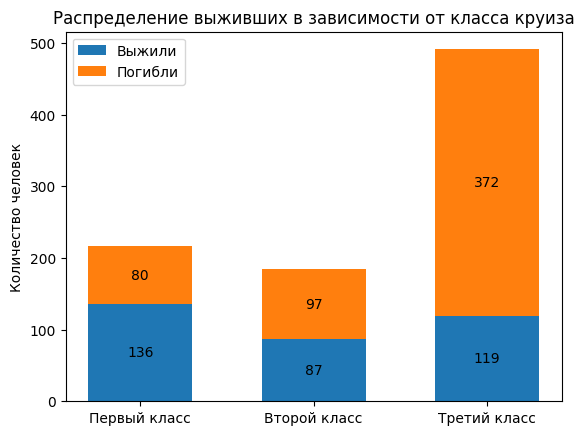

In [95]:
#Посчитаем общее количество для каждого из классов круиза и количество выживших
first_total = len(df.loc[(df['Pclass'] == 1)])
second_total = len(df.loc[(df['Pclass'] == 2)])
third_total = len(df.loc[(df['Pclass'] == 3)])
first_survived = len(df.loc[((df['Pclass'] == 1) & (df['Survived'] == 1))])
second_survived = len(df.loc[((df['Pclass'] == 2) & (df['Survived'] == 1))])
third_survived = len(df.loc[((df['Pclass'] == 3) & (df['Survived'] == 1))])

#Визуализируем
survivors_counts = {
    'Выжили': [first_survived, second_survived, third_survived],
    'Погибли': [first_total - first_survived, second_total - second_survived, third_total - third_survived]
}

fig, ax = plt.subplots()
bottom = np.zeros(3)

for key, count in survivors_counts.items():
    p = ax.bar(('Первый класс', 'Второй класс', 'Третий класс'), count, width = 0.6, label = key, bottom = bottom)
    bottom += count
    ax.bar_label(p, label_type = 'center')

ax.set_title('Распределение выживших в зависимости от класса круиза')
ax.set_ylabel('Количество человек')
ax.legend()
plt.show()

In [96]:
#Вывод: в целом прослеживается отрицательное влияние количества полных лет человека на Survived (пункт 8 ДЗ)
col_analyser(df, 'Survived', ['Age'])

Age : 89
       COUNT     RATIO  SURVIVED_MEAN
0.42       1  0.001122            1.0
0.67       1  0.001122            1.0
0.75       2  0.002245            1.0
0.83       2  0.002245            1.0
0.92       1  0.001122            1.0
...      ...       ...            ...
70.00      2  0.002245            0.0
70.50      1  0.001122            0.0
71.00      2  0.002245            0.0
74.00      1  0.001122            0.0
80.00      1  0.001122            1.0

[89 rows x 3 columns]




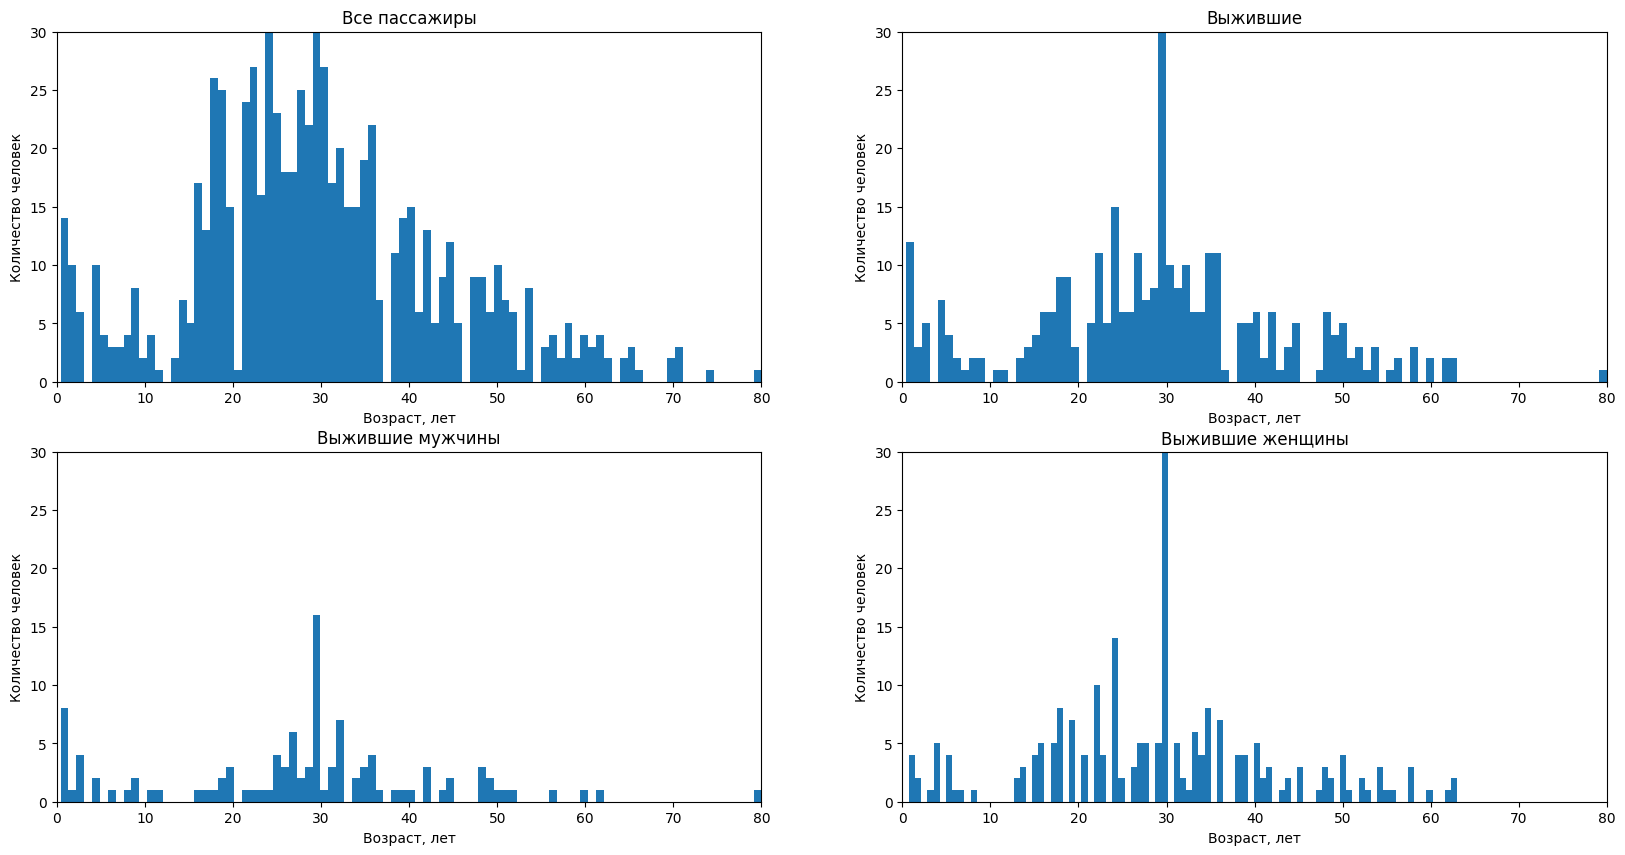

In [98]:
#Выберем списки пассжиров в отдельные группы
survivors = df.loc[(df['Survived'] == 1)]
male_survivors = df.loc[((df['Male'] == 1) & (df['Survived'] == 1))]
female_survivors = df.loc[((df['Male'] == 0) & (df['Survived'] == 1))]

#Число возрастов
num_of_ages = len(dict(Counter(df['Age'])).keys())

#Визуализируем
fig, axs = plt.subplots(2,2)
fig.set_figwidth(20)
fig.set_figheight(10)
names = [['Все пассажиры', 'Выжившие'], ['Выжившие мужчины', 'Выжившие женщины']]
for i, surv in enumerate([[df, survivors], [male_survivors, female_survivors]]):
    for j, subsurv in enumerate(surv):
        axs[i][j].hist(subsurv['Age'], bins = num_of_ages)
        axs[i][j].set_title(names[i][j])
        axs[i][j].set_xlabel('Возраст, лет')
        axs[i][j].set_ylabel('Количество человек')
        axs[i][j].set_ylim(0, 30)
        axs[i][j].set_xlim(0, 80)
plt.show()

In [99]:
#Выживших в зависимости от числа братьев, сестер, супруга на борту: 0 - 36%, 1 - 54%, 2 - 46%, 3 - 25%, 4 - 17%, 5 - 0%, 8 - 0%
#Вывод: отрицательное влияние числа братьев, сестер, супруга > 1 на борту на Survived (пункт 8 ДЗ)
col_analyser(df, 'Survived', ['SibSp'])

SibSp : 7
   COUNT     RATIO  SURVIVED_MEAN
0    608  0.682379       0.345395
1    209  0.234568       0.535885
2     28  0.031425       0.464286
3     16  0.017957       0.250000
4     18  0.020202       0.166667
5      5  0.005612       0.000000
8      7  0.007856       0.000000




In [100]:
#Выживших в зависимости от количества родителей или детей, с которыми путешествовал пассажир: 0 - 34%, 1 - 55%, 2 - 50%, 3 - 60%, 4 - 0%, 5 - 20%, 6 - 0%
#Вывод: отрицательное влияние количества родителей или детей, с которыми путешествовал каждый пассажир > 3 на борту на Survived (пункт 8 ДЗ)
col_analyser(df, 'Survived', ['Parch'])

Parch : 7
   COUNT     RATIO  SURVIVED_MEAN
0    678  0.760943       0.343658
1    118  0.132435       0.550847
2     80  0.089787       0.500000
3      5  0.005612       0.600000
4      4  0.004489       0.000000
5      5  0.005612       0.200000
6      1  0.001122       0.000000




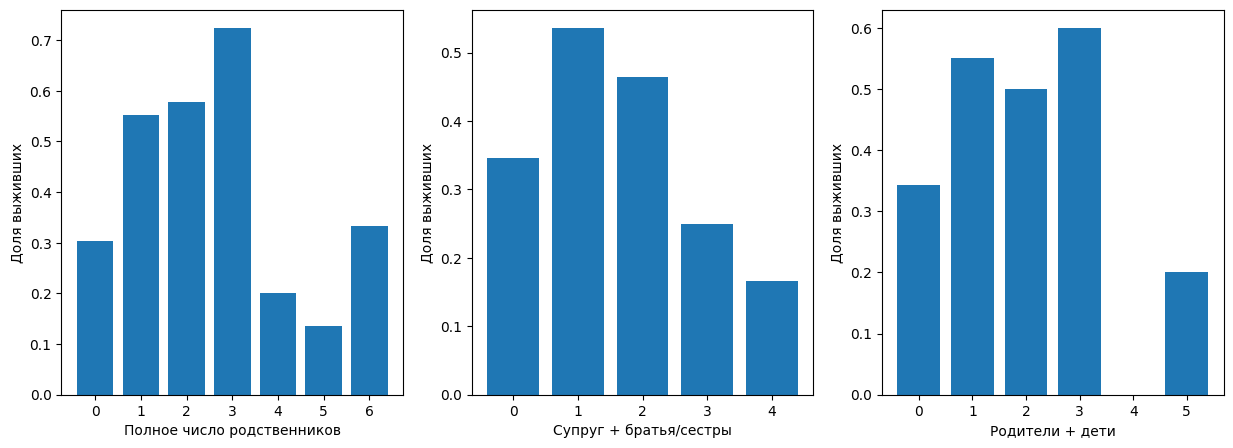

In [101]:
#Признаки "Родители + дети" и "Супруг + братья/сестры" можно объединить в один признак "Семья"
df2 = df.copy()
df2['Family'] = np.array(df2['SibSp'], int) + np.array(df2['Parch'], int)
sibsp_total = dict(Counter(df2['SibSp']))
parch_total = dict(Counter(df2['Parch']))
family_total = dict(Counter(df2['Family']))
sibsp_survived = dict(Counter(df2.loc[(df2['Survived'] == 1)]['SibSp']))
parch_survived = dict(Counter(df2.loc[(df2['Survived'] == 1)]['Parch']))
family_survived = dict(Counter(df2.loc[(df2['Survived'] == 1)]['Family']))
relatives = (family_total, sibsp_total, parch_total)
relatives_survived = (family_survived, sibsp_survived, parch_survived)

fig, axs = plt.subplots(1, 3, figsize=(15,5))
xlabs = ('Полное число родственников', 'Супруг + братья/сестры', 'Родители + дети')

for i in range(3):
    probs = []
    for rel, amount in relatives_survived[i].items():
        probs.append(amount / relatives[i][rel])
    axs[i].bar(relatives_survived[i].keys(), probs)
    axs[i].set_ylabel('Доля выживших')
    axs[i].set_xlabel(xlabs[i])
plt.show()

In [102]:
#С ростом стоимости билета, количество выживших, в целом больше
#Вывод: положительное влияние цены билета на Survived (пункт 8 ДЗ)
col_analyser(df, 'Survived', ['Fare'])

Fare : 248
          COUNT     RATIO  SURVIVED_MEAN
0.0000       15  0.016835       0.066667
4.0125        1  0.001122       0.000000
5.0000        1  0.001122       0.000000
6.2375        1  0.001122       0.000000
6.4375        1  0.001122       0.000000
...         ...       ...            ...
227.5250      4  0.004489       0.750000
247.5208      2  0.002245       0.500000
262.3750      2  0.002245       1.000000
263.0000      4  0.004489       0.500000
512.3292      3  0.003367       1.000000

[248 rows x 3 columns]




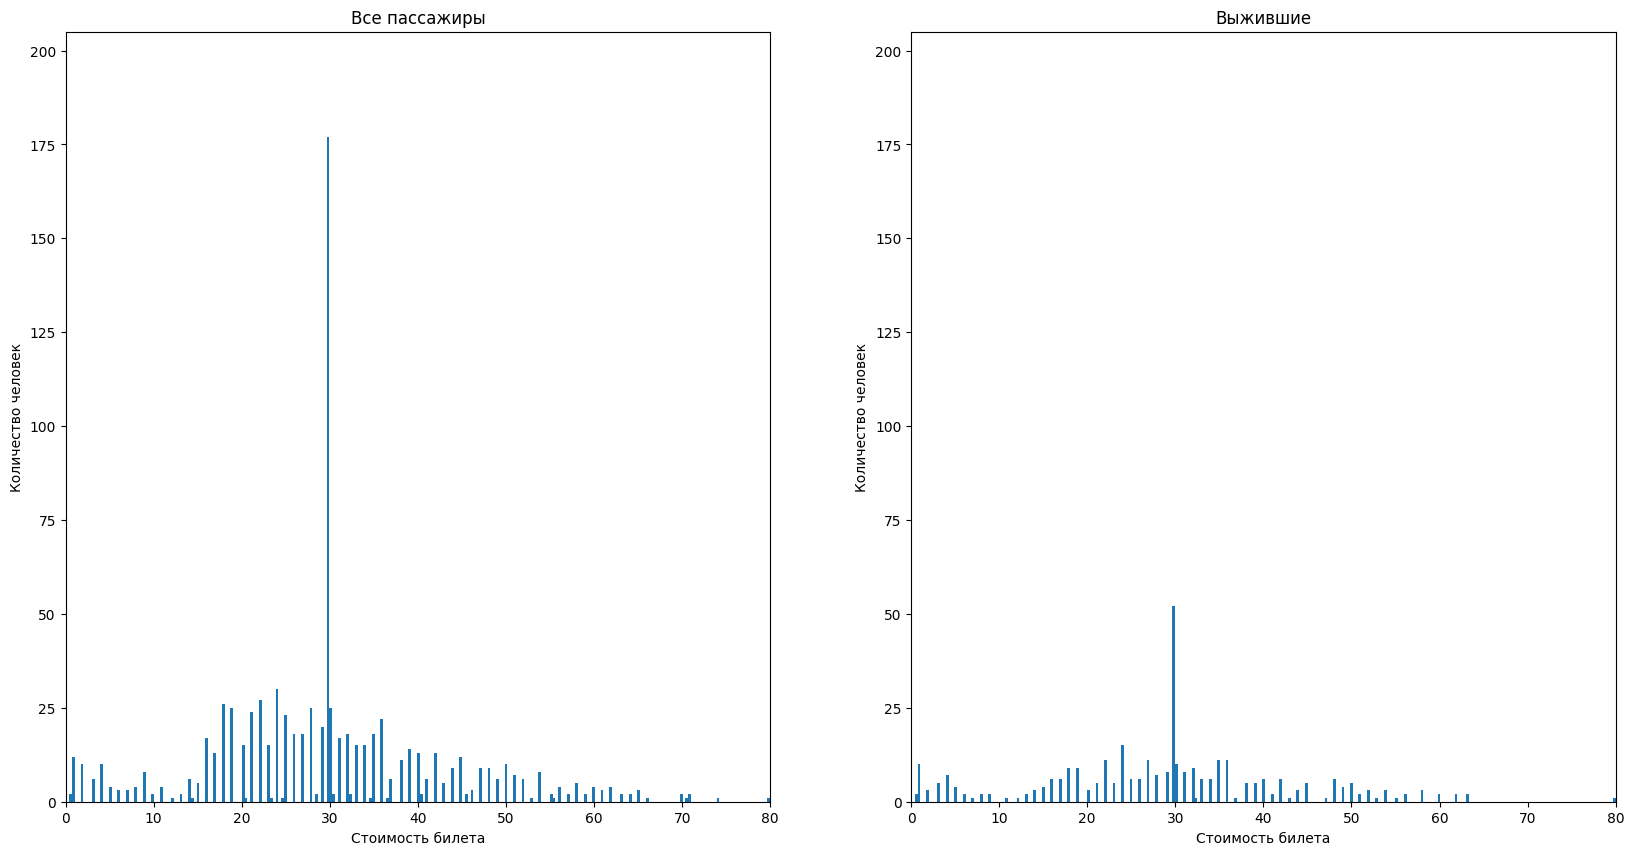

In [103]:
survivors = df.loc[(df['Survived'] == 1)]
#Число стоимостей
num_of_costs = len(dict(Counter(df['Fare'])).keys())
#Визуализируем
fig, axs = plt.subplots(1,2)
fig.set_figwidth(20)
fig.set_figheight(10)
names = ['Все пассажиры', 'Выжившие']
for i, subsurv in enumerate([df, survivors]):
    axs[i].hist(subsurv['Age'], bins=num_of_costs)
    axs[i].set_title(names[i])
    axs[i].set_xlabel('Стоимость билета')
    axs[i].set_ylabel('Количество человек')
    axs[i].set_ylim(0, 205)
    axs[i].set_xlim(0, 80)
plt.show()

In [104]:
col_analyser(df, 'Survived', ['Embarked'])

Embarked : 3
   COUNT     RATIO  SURVIVED_MEAN
C    168  0.188552       0.553571
Q     77  0.086420       0.389610
S    646  0.725028       0.339009




In [105]:
#Количество выживших пассажиров больше из порта С, но эта зависимость, скорее всего носит случайный характер и
#связана с тем, что среди пассажиров, поднявшихся на борт в порту C  - 50% составляли пассажиры 1 класса и 10% пассажиры 2 класса, а выживаемость среди них больше.
#Поэтому этот категориальный признак будет исключен из дальнейшего анализа
df.groupby(["Embarked"])["Pclass"].value_counts(normalize=True)

Embarked  Pclass
C         1         0.505952
          3         0.392857
          2         0.101190
Q         3         0.935065
          2         0.038961
          1         0.025974
S         3         0.546440
          2         0.253870
          1         0.199690
Name: Pclass, dtype: float64

In [106]:
df2 = df.copy()
X = df2.drop(['PassengerId', 'Name', 'Ticket', 'Embarked', 'Survived'], axis=1)
Y = df2['Survived']
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size = 0.8, test_size = 0.2, random_state = 0)

In [107]:
std = StandardScaler()
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

,Pclass,Age,SibSp,Parch,Fare,Cabin_available,Male
count,7.120000e+02,7.120000e+02,7.120000e+02,7.120000e+02,7.120000e+02,7.120000e+02,7.120000e+02
mean,-1.871162e-16,-4.191404e-16,1.496930e-17,3.991813e-17,1.047851e-16,-1.247442e-17,3.368092e-17
std,1.000703e+00,1.000703e+00,1.000703e+00,1.000703e+00,1.000703e+00,1.000703e+00,1.000703e+00
min,-1.581187e+00,-2.222129e+00,-4.644523e-01,-4.774102e-01,-6.359859e-01,-5.448885e-01,-1.372075e+00
25%,-3.809684e-01,-5.914295e-01,-4.644523e-01,-4.774102e-01,-4.779482e-01,-5.448885e-01,-1.372075e+00
50%,8.192506e-01,-2.824373e-03,-4.644523e-01,-4.774102e-01,-3.474385e-01,-5.448885e-01,7.288229e-01
75%,8.192506e-01,4.024333e-01,4.127096e-01,-4.774102e-01,-1.173551e-02,-5.448885e-01,7.288229e-01
max,8.192506e-01,3.842728e+00,6.552843e+00,6.832612e+00,9.590128e+00,1.835238e+00,7.288229e-01


,Pclass,Age,SibSp,Parch,Fare,Cabin_available,Male
count,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000
mean,-0.052417,-0.014059,-0.028322,-0.062223,0.033905,0.000280,-0.057547
std,1.016139,0.969634,0.823136,0.904983,0.958246,1.002986,1.019565
min,-1.581187,-2.241242,-0.464452,-0.477410,-0.635986,-0.544888,-1.372075
25%,-1.581187,-0.591430,-0.464452,-0.477410,-0.476846,-0.544888,-1.372075
50%,0.819251,-0.002824,-0.464452,-0.477410,-0.356545,-0.544888,0.728823
75%,0.819251,0.325982,0.412710,-0.477410,-0.027205,-0.544888,0.728823
max,0.819251,2.619512,3.921358,5.614275,4.613506,1.835238,0.728823


In [108]:
Evaluation_Results = pd.DataFrame(np.zeros((1,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
Evaluation_Results.index=['Logistic Regression (LR)']

In [109]:
def classification_summary(pred, pred_prob, i):
    Evaluation_Results.iloc[i]['Accuracy'] = round(accuracy_score(Test_Y, pred),3) * 100
    Evaluation_Results.iloc[i]['Precision'] = round(precision_score(Test_Y, pred, average = 'weighted'), 3) * 100
    Evaluation_Results.iloc[i]['Recall'] = round(recall_score(Test_Y, pred, average = 'weighted'), 3) * 100
    Evaluation_Results.iloc[i]['F1-score'] = round(f1_score(Test_Y, pred, average = 'weighted'), 3) * 100
    Evaluation_Results.iloc[i]['AUC-ROC score'] = round(roc_auc_score(Test_Y, pred_prob[:,1], multi_class='ovr'), 3) * 100
    print('{}{}Evaluating {}{}{}\n'.format('<' * 3, '-' * 35, Evaluation_Results.index[i], '-' * 35, ' >' * 3))
    print('Accuracy = {}%'.format(round(accuracy_score(Test_Y, pred), 3) * 100))
    print('F1 Score = {}%'.format(round(f1_score(Test_Y, pred, average='weighted'),3)*100))
    print('\nConfusiton Matrix:\n[]',confusion_matrix(Test_Y, pred))
    print('\nClassification Report:\n',classification_report(Test_Y, pred))

In [110]:
#Logistic Regression

LR_model = LogisticRegression()

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l2']
space['C'] = loguniform(1e-5, 100)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(LR_model, space, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

LR = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = LR.predict(Test_X_std)
pred_prob = LR.predict_proba(Test_X_std)
classification_summary(pred,pred_prob,0)

print('\nInterpreting the Output of Logistic Regression:\n')

print('intercept ', LR.intercept_[0])
print('classes', LR.classes_)
display(pd.DataFrame({'coeff': LR.coef_[0]}, index=Train_X_std.columns))



<<<-----------------------------------Evaluating Logistic Regression (LR)----------------------------------- > > >

Accuracy = 82.1%
F1 Score = 82.1%

Confusiton Matrix:
[] [[94 16]
 [16 53]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       110
           1       0.77      0.77      0.77        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179


Interpreting the Output of Logistic Regression:

intercept  -0.5869133646250714
classes [0 1]


,coeff
Pclass,-0.458414
Age,-0.378624
SibSp,-0.274187
Parch,-0.035520
Fare,0.114952
Cabin_available,0.255476
Male,-1.014272


In [ ]:
#Ориентируясь на знаки коэффициентов логистической регрессии можно сделать вывод, что:
#Величина номера класса круиза Pclass отрицательно влияла на выживаемость Survived - среди пассажиров 1 класса больше выживших
#Возраст Age отрицательно влиял на выживаемость Survived - среди более молодых пассажиров больше выживших
#Число братьев,сестер или супруга на борту у человека SibSp отрицательно влияла на выживаемость Survived
#Количество родителей или детей, с которыми путешествовал каждый пассажир Parch отрицательно влияла на выживаемость Survived
#Цена билета Fare положительно влияла на выживаемость Survived
#Наличие отдельной каюты Cabin_available положительно влияла на выживаемость Survived
#Принадлежность к мужскому полу Male отрицательно влияла на выживаемость Survived
#Это согласуется с выводами,полученными ранее на основе простой попарной группировки признаков